# Comparing Networks

In this notebook, we want to compare different network to each other.
We will start of with...

- Untrained Model
- Trained Model
- Trained Model (Exact Unlearning)*$^1$

All these model should serve as comparison point for approximate MU Algorithms, which we want to try out

*$^1$ Exact Unlearning: refers to an complete retraining of the Model, without the samples which we want to unlearn.

In [1]:
import os
import sys

# Add the parent directory to sys.path
sys.path.append(os.path.join('..', 'src'))

import torch
from torch.utils.data import DataLoader
import copy
from PIL import Image
import numpy as np
from helper import get_model
from mlp_dataclass import MNIST_CostumDataset, TwoLayerPerceptron
from training import main

EXAMPLE = f"..{os.sep}data{os.sep}mnist_dataset{os.sep}7e{os.sep}test_0.png"

c:\Users\Moritz\miniconda3\envs\bach.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def prepare_sample(path:str):
    """preps sample to pass to model, transforms to tensor, reshape to 784, shaping it as batch"""
    sample = Image.open(path).convert("L")
    sample = torch.Tensor(np.array(sample)).reshape(784)
    
    return sample.unsqueeze(0)

def show_sample(sample:torch.Tensor):
    """Converts the sample to a numpy array and reshapes it to a 28x28 image"""
    sample = sample.reshape(28, 28)
    sample = sample.numpy()
    sample = Image.fromarray(sample)
    return sample

In [3]:
show_sample(prepare_sample(EXAMPLE)).show()

____

### Untrained Model

We want to include an untrained model as a pour reference point.

Later, we will compare the differently trained (and untrained) models on different metrics. We are thinking, that the **untrained model should always be the furthest neighbor** and see if thats true. Also out of pur curiosity, how do the models compare according to the found metrics to the untrained model.

It could be interesting to see, if the unlearned models tend to be more similar to the "Exact MU Model" or to the "Untrained Model"

The "Trained Model"´s and "Exact Model"´s starting point is the "Untrained Model". That means all models can be traced back to it.

In [4]:
# untrained_model = TwoLayerPerceptron(input_dim=784, output_dim=10)

# torch.save(untrained_model.state_dict(), f"..{os.sep}data{os.sep}models{os.sep}untrained_model")

# print("Shape of Tenosr: ", prepare_sample(EXAMPLE).shape)
# untrained_model(prepare_sample(EXAMPLE))

In [5]:
untrained_model = TwoLayerPerceptron(input_dim=784, output_dim=10)
untrained_model.load_state_dict(torch.load(f"..{os.sep}data{os.sep}models{os.sep}untrained_model", weights_only=True))
untrained_model.eval()

TwoLayerPerceptron(
  (fc1): Linear(in_features=784, out_features=800, bias=True)
  (fc3): Linear(in_features=800, out_features=10, bias=True)
)

In [6]:
print("Shape of Tenosr: ", prepare_sample(EXAMPLE).shape)
print(untrained_model(prepare_sample(EXAMPLE)))
torch.max(untrained_model(prepare_sample(EXAMPLE)), 1)

Shape of Tenosr:  torch.Size([1, 784])
tensor([[-1.4305e-06, -3.3952e+01, -4.6039e+01, -1.4157e+01, -1.8464e+01,
         -3.3265e+01, -4.0250e+01, -4.1240e+01, -1.4187e+01, -4.3337e+01]],
       grad_fn=<LogSoftmaxBackward0>)


torch.return_types.max(
values=tensor([-1.4305e-06], grad_fn=<MaxBackward0>),
indices=tensor([0]))

___

### Trained Model

This model will be the starting point for all MU algorithms. The more it is important that it does not change throughout the experiments, otherwise we need to run everything again.

Notes Regarding the Dataloader: We included Up-/Downsampling. There is a counter in the Dataset class, which controls, which class is next to provide a sample. From the available pool a sample will be chosen at random.

Reason: The amount of available samples should not influence the performance of the model on certain classes.

Regarding the samples for the class "7": There are more samples of sevens without a middle line than ones with.

Ratio: 
- 6268 (train: 5385, test: 883)
- 1025 (train: 880,  test: 145)

Should there be concerns regarding that the bigger part of the sevens (without middle line) will be unlearning?

In [7]:
# main(
#     new_name="trained_model",
#     model=copy.deepcopy(untrained_model),
#     sampling_mode="all",
#     balanced_sampling=True,
# )

Epoch [1/10] - Train Loss: 10.2791 - Val Loss: 3.7059 - Train Accuracy: 0.7190 - Val Accuracy: 0.8291
                                                                   
Epoch [2/10] - Train Loss: 3.1310 - Val Loss: 1.9731 - Train Accuracy: 0.8250 - Val Accuracy: 0.8330
                                                                   
Epoch [3/10] - Train Loss: 1.9117 - Val Loss: 1.6126 - Train Accuracy: 0.8360 - Val Accuracy: 0.8395
                                                                   
Epoch [4/10] - Train Loss: 1.2980 - Val Loss: 1.4563 - Train Accuracy: 0.8530 - Val Accuracy: 0.8354
                                                                   
Epoch [5/10] - Train Loss: 0.9279 - Val Loss: 0.9853 - Train Accuracy: 0.8780 - Val Accuracy: 0.8581
                                                                   
Epoch [6/10] - Train Loss: 0.8566 - Val Loss: 0.5171 - Train Accuracy: 0.8880 - Val Accuracy: 0.9131
                                                                   
Epoch [7/10] - Train Loss: 0.6793 - Val Loss: 0.4452 - Train Accuracy: 0.9000 - Val Accuracy: 0.9159
                                                                   
Epoch [8/10] - Train Loss: 0.3773 - Val Loss: 0.3985 - Train Accuracy: 0.9260 - Val Accuracy: 0.9213
                                                                   
Epoch [9/10] - Train Loss: 0.2953 - Val Loss: 0.3818 - Train Accuracy: 0.9430 - Val Accuracy: 0.9239
                                                                   
Epoch [10/10] - Train Loss: 0.3581 - Val Loss: 0.3543 - Train Accuracy: 0.9140 - Val Accuracy: 0.9273

Model saved to:  ..\data\models\all\TwoLayerPerceptron_b_trained_model

In [8]:
trained_model = get_model("trained")

___

### Exact Unlearned Model

This model has the same training conditions as the "Trained Model", with the only difference being, that it had no sevens __with no middle line__

In [9]:
# main(
#     new_name="exact_model",
#     model=copy.deepcopy(untrained_model),
#     sampling_mode="except_erased",
#     balanced_sampling=True,
# )

Epoch [1/10] - Train Loss: 11.0494 - Val Loss: 3.9705 - Train Accuracy: 0.6790 - Val Accuracy: 0.8060
                                                                   
Epoch [2/10] - Train Loss: 2.8843 - Val Loss: 2.0364 - Train Accuracy: 0.8210 - Val Accuracy: 0.8452
                                                                   
Epoch [3/10] - Train Loss: 1.9582 - Val Loss: 1.9326 - Train Accuracy: 0.8260 - Val Accuracy: 0.8066
                                                                   
Epoch [4/10] - Train Loss: 1.0714 - Val Loss: 0.6197 - Train Accuracy: 0.8630 - Val Accuracy: 0.9021
                                                                   
Epoch [5/10] - Train Loss: 0.9799 - Val Loss: 0.7909 - Train Accuracy: 0.8540 - Val Accuracy: 0.8872
                                                                   
Epoch [6/10] - Train Loss: 0.5125 - Val Loss: 0.5123 - Train Accuracy: 0.9140 - Val Accuracy: 0.9135
                                                                   
Epoch [7/10] - Train Loss: 0.3382 - Val Loss: 0.4401 - Train Accuracy: 0.9360 - Val Accuracy: 0.9180
                                                                   
Epoch [8/10] - Train Loss: 0.6186 - Val Loss: 0.3889 - Train Accuracy: 0.8990 - Val Accuracy: 0.9229
                                                                   
Epoch [9/10] - Train Loss: 0.4423 - Val Loss: 0.3394 - Train Accuracy: 0.9170 - Val Accuracy: 0.9277
                                                                   
Epoch [10/10] - Train Loss: 0.4092 - Val Loss: 0.3211 - Train Accuracy: 0.9370 - Val Accuracy: 0.9291

Model saved to:  ..\data\models\except_erased\TwoLayerPerceptron_b_exact_model

In [10]:
exact_model = get_model("exact")

___

## Metrics

In [11]:
from metrics import calc_accuracy
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

### Accuracy

- $D_{Gesamt}$
- $D_{Erased}$
- $D_{Remain}$
- $D_{Accuracy Per Class}$

In [12]:
# first we need to prepare the dataloaders

D_GESAMT = DataLoader(
    dataset=MNIST_CostumDataset(
        sample_mode="all",
        train=True,
        test=True,
    ),
    batch_size=1,
    shuffle=False
)

D_ERASED = DataLoader(
    dataset=MNIST_CostumDataset(
        sample_mode="only_erased",
        train=True,
        test=True,
    ),
    batch_size=1,
    shuffle=False
)

D_REMAIN = DataLoader(
    dataset=MNIST_CostumDataset(
        sample_mode="except_erased",
        train=True,
        test=True,
    ),
    batch_size=1,
)

D_CLASSES = {k: DataLoader(dataset=MNIST_CostumDataset(sample_mode="all", classes=[k], train=True, test=True,), batch_size=1, shuffle=False) for k in ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]}

In [13]:
# a function will help to caplse metric clac
def evaluate_model(model: TwoLayerPerceptron):
    """"""

    a_gesamt = calc_accuracy(model, D_GESAMT)
    a_erased = calc_accuracy(model, D_ERASED)
    a_remain = calc_accuracy(model, D_REMAIN)

    
    print(f"Accuracy gesamt: {a_gesamt:.3f} - Erased: {a_erased:.3f} - Remain: {a_remain:.3f}")

    a_classes = {k: calc_accuracy(model, v) for k, v in D_CLASSES.items()}
    # Create the bar plot
    plt.figure(figsize=(8, 6))
    bars = plt.bar(a_classes.keys(), a_classes.values(), color='blue')

    # Set y-axis limits from 0 to 1
    plt.ylim(0, 1)

    # Add labels and title
    plt.xlabel('Classes')
    plt.ylabel('Accuracy')
    plt.title('The Average Accuracy of Each Class')

    # Show the exact value on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 2), ha='center', va='bottom')


    # Display the plot
    plt.show()
    pass


Now, let us see what metrics each model has

Accuracy gesamt: 0.088 - Erased: 0.002 - Remain: 0.096


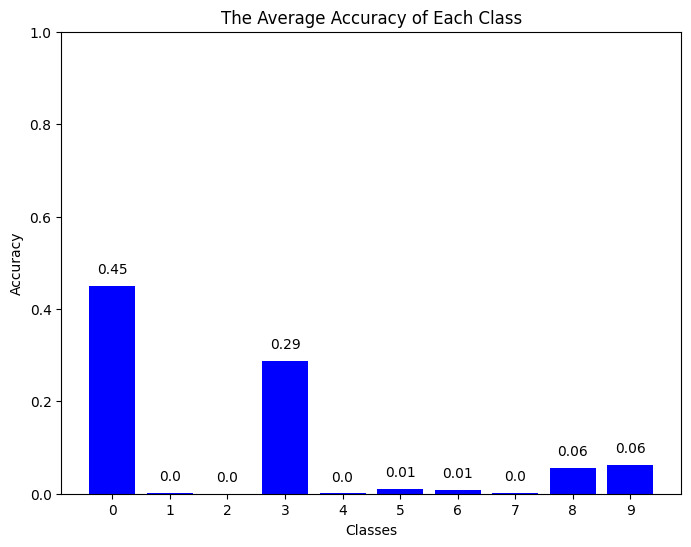

In [14]:
evaluate_model(untrained_model)

Accuracy gesamt: 0.930 - Erased: 0.963 - Remain: 0.927


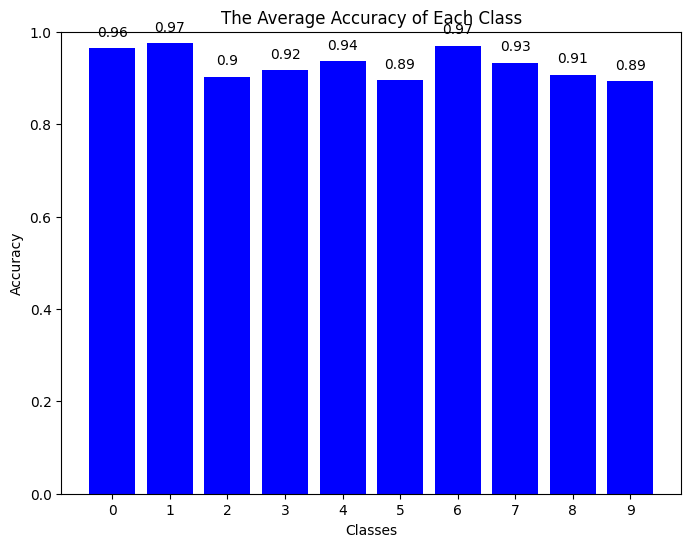

In [15]:
evaluate_model(trained_model)

Stop Criterium von 10 nicht fair, da es sich implizit 

- Wie verhält sich das Unlearning über die Anzahl der Epochen?

- Man sollte sich den Loss als Referenz anschauen

- Festes Downsampling, wenn die 7 reduzierte Samples haben, müssten auch die anderen Klassen weniger Samples in der Grundmenge haben.

- auf einen weiteren Datensatz soll es auch getestet werden. (C_MNIST wie robust ist der Algorithmus gegenüber Rausche)
    - ggf. auf weiterem Datensatz ein Merkmal versuchen zu Unlearnen

Accuracy gesamt: 0.915 - Erased: 0.761 - Remain: 0.930


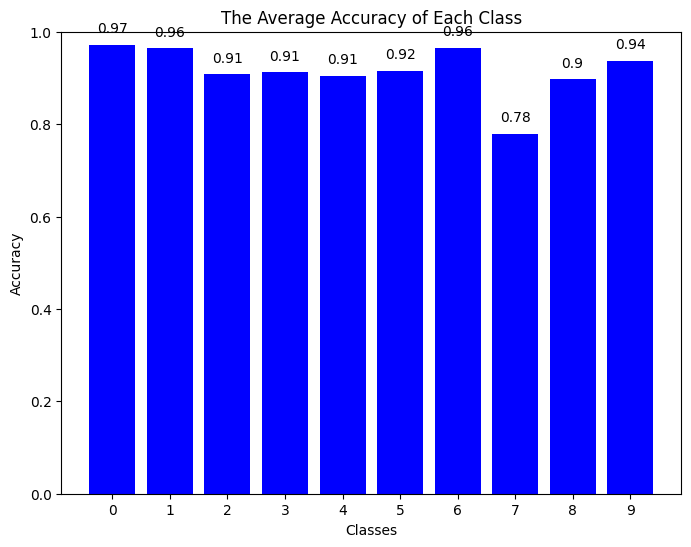

In [16]:
evaluate_model(exact_model)

In [17]:
sum([1 for _, x in D_CLASSES["7"].dataset.samples.items() if "7e" in x["image"]])


6268